# Workshop on design and build a spatial reasoning system: Point cloud classification using PointNet

Course: NICF- Spatial Reasoning from Sensor Data (SF), https://www.iss.nus.edu.sg/executive-education/course/detail/spatial-reasoning-from-sensor-data/artificial-intelligence

Contact: Tian Jing

Email: tianjing@nus.edu.sg

## Objective

- Visualize the point cloud data
- Perform point cloud classification using the PointNet approach

## Installation guideline (local computer)

- Open `Anaconda Prompt`

- Append the channel `conda-forge` into your conda configuration.

`conda config --append channels conda-forge`

- Create a new virtual environment `srsdv` or install additional packages in your own environment

**[Windows, CPU version]**

`conda create -n srsdv python=3.6 numpy=1.15.1 opencv=3.4.2 matplotlib=2.2.3 tensorflow=1.10.0 scipy=1.1.0 scikit-learn=0.19.1 spyder=3.3.2 yaml=0.1.7 keras=2.2.4 pillow=5.4.1 notebook=5.7.4 pandas=0.24.2 h5py=2.8.0`

**[Windows, GPU version, CUDA 9.0]**

`conda create -n srsdv python=3.6 numpy=1.15.1 opencv=3.4.2 matplotlib=2.2.3 tensorflow-gpu=1.12.0 scipy=1.1.0 scikit-learn=0.19.1 spyder=3.3.2 yaml=0.1.7 keras-gpu=2.2.4 pillow=5.4.1 notebook=5.7.4 pandas=0.24.2 h5py=2.8.0`

- Activate the environment `srsdv`

`conda activate srsdv`

- Browse to the folder that contains the workshop files, then run `Jupyter Notebook`

`jupyter notebook`

## Reference

- Dataset: ModelNet10, http://modelnet.cs.princeton.edu/
    
## Submission guideline

Once you finish the workshop, rename your .ipynb file to your name, and submit your .ipynb file into LumiNUS.


In [ ]:
# Check GPU setup in Colab
%tensorflow_version 1.x
import tensorflow as tf

# Silence the tensorflow warning message
tf.get_logger().setLevel('ERROR')

# Check GPU coinfiguration in Colab (T4 GPU)
print("Tensorflow version: ", tf.__version__)
print(tf.test.gpu_device_name())
# Your expected output will be '/device:GPU:0'


TensorFlow 1.x selected.
Tensorflow version:  1.15.2
/device:GPU:0


In [ ]:
# Then you’ll see a link, click on that link, allow access
# Copy the code that pops up, paste it in the box, hit enter

from google.colab import drive
drive.mount('/content/gdrive')

# Change working directory to be current folder, please keep ''/content/gdrive/My Drive/XXX' in the path and change XXX to be your own folder.
# The path is case sensitive.
import os
os.chdir('/content/gdrive/My Drive/SRSD/point_cloud')
!ls

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
data
demo_point_cloud_mvcnn_v3.0.ipynb
demo_point_cloud_pointnet_v3.0.ipynb
wk_point_cloud_colab_v202009_solution.ipynb
wk_point_cloud_colab_v2.0.ipynb
wk_point_cloud_colab_v3.0.ipynb


In [ ]:
import numpy as np
import os
import tensorflow as tf
import keras
from keras import optimizers
from keras.layers import Input
from keras.models import Model, Sequential
from keras.models import model_from_json, load_model
from keras.layers import Dense, Flatten, Reshape, Dropout
from keras.layers import Convolution1D, MaxPooling1D, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Lambda, Layer
from keras.callbacks import ModelCheckpoint
import h5py
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import confusion_matrix
import pandas as pd


Using TensorFlow backend.


In [ ]:
# Load train and test data
# The data is of shape: ( _n_ x number of points x coordinates (x,y,z) ).
# We have 3991 samples in our training set and 908 in our test with each sample (3D object)
# has 2048 points represented by an x, y, z coordinates.

modelnet10_categories = ['bathtub','bed','chair','desk','dresser','monitor','night_stand','sofa','table','toilet']
f = h5py.File("data/modelnet10_train.h5", "r")
train_points_r = f['data'][:]
train_labels_r = f['label'][:]

train_points_r = np.array(train_points_r)
train_labels_r = np.array(train_labels_r)
print("Training data shape: ", train_points_r.shape)
print("Training label shape: ", train_labels_r.shape)

f = h5py.File("data/modelnet10_test.h5", "r")
test_points_r = f['data'][:]
test_labels_r = f['label'][:]

test_points_r = np.array(test_points_r)
test_labels_r = np.array(test_labels_r)
print("Test data shape: ", test_points_r.shape)
print("Test label shape: ", test_labels_r.shape)

Training data shape:  (3991, 2048, 3)
Training label shape:  (3991, 1)
Test data shape:  (908, 2048, 3)
Test label shape:  (908, 1)


## Exercise 1: Visualize a point cloud

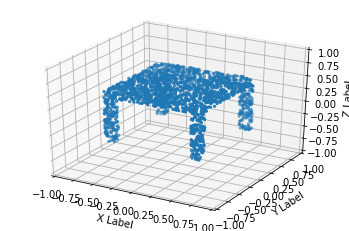

The displayed point cloud data is table


In [ ]:
# plot point cloud 
def plot_ply(file):
    fig = plt.figure()
    ax = fig.add_subplot(111,projection='3d')
    ax.set_ylim(-1,1)
    ax.set_xlim(-1,1)
    ax.set_zlim(-1,1)
    x=file[:,0]
    y=file[:,1]
    z=file[:,2]
    ax.scatter(x, y, z, marker='.', zdir='z')
    ax.set_xlabel('X Label')
    ax.set_ylabel('Y Label')
    ax.set_zlabel('Z Label')
    plt.show()
    
# Randomly select one point cloud data (0 - 3991) and illustrate
data_idx = 0
plot_ply(train_points_r[data_idx])
print("The displayed point cloud data is", modelnet10_categories[train_labels_r[data_idx][0]])

## Exercise 2: Point cloud classification using PointNet

- Reference: R. Qi, H. Su, M. Kaichun, L. J. Guibas, "PointNet: Deep Learning on Point Sets for 3D Classification and Segmentation," CVPR 2017, pp. 77-85.

In [ ]:
# Setting for model training
# number of points in each sample
num_points = 2048

# number of categories
k = 10

# define optimizer
adam = optimizers.Adam(lr=0.001, decay=0.7)

# label to categorical
Y_train = keras.utils.to_categorical(train_labels_r, k)
Y_test = keras.utils.to_categorical(test_labels_r, k)

In [ ]:
# input_Transformation_net
input_points = Input(shape=(num_points, 3))
x = Convolution1D(64, 1, activation='relu', input_shape=(num_points, 3))(input_points)
x = BatchNormalization()(x)
x = Convolution1D(128, 1, activation='relu')(x)
x = BatchNormalization()(x)
x = Convolution1D(1024, 1, activation='relu')(x)
x = BatchNormalization()(x)
x = MaxPooling1D(pool_size=num_points)(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dense(9, weights=[np.zeros([256, 9]), np.array([1, 0, 0, 0, 1, 0, 0, 0, 1]).astype(np.float32)])(x)
input_T = Reshape((3, 3))(x)

def mat_mul(A, B):
    return tf.matmul(A, B)

# forward net
g = Lambda(mat_mul, arguments={'B': input_T})(input_points)
g = Convolution1D(64, 1, input_shape=(num_points, 3), activation='relu')(g)
g = BatchNormalization()(g)
g = Convolution1D(64, 1, input_shape=(num_points, 3), activation='relu')(g)
g = BatchNormalization()(g)

# feature transform net
f = Convolution1D(64, 1, activation='relu')(g)
f = BatchNormalization()(f)
f = Convolution1D(128, 1, activation='relu')(f)
f = BatchNormalization()(f)
f = Convolution1D(1024, 1, activation='relu')(f)
f = BatchNormalization()(f)
f = MaxPooling1D(pool_size=num_points)(f)
f = Dense(512, activation='relu')(f)
f = BatchNormalization()(f)
f = Dense(256, activation='relu')(f)
f = BatchNormalization()(f)
f = Dense(64 * 64, weights=[np.zeros([256, 64 * 64]), np.eye(64).flatten().astype(np.float32)])(f)
feature_T = Reshape((64, 64))(f)

# forward net
g = Lambda(mat_mul, arguments={'B': feature_T})(g)
g = Convolution1D(64, 1, activation='relu')(g)
g = BatchNormalization()(g)
g = Convolution1D(128, 1, activation='relu')(g)
g = BatchNormalization()(g)
g = Convolution1D(1024, 1, activation='relu')(g)
g = BatchNormalization()(g)

# global_feature
global_feature = MaxPooling1D(pool_size=num_points)(g)

# point_net_cls
c = Dense(512, activation='relu')(global_feature)
c = BatchNormalization()(c)
c = Dropout(rate=0.7)(c)
c = Dense(256, activation='relu')(c)
c = BatchNormalization()(c)
c = Dropout(rate=0.7)(c)
c = Dense(k, activation='softmax')(c)
prediction = Flatten()(c)

# print the model summary
model_pointnet = Model(inputs=input_points, outputs=prediction)
print(model_pointnet.summary())


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 2048, 3)           0         
_________________________________________________________________
lambda_1 (Lambda)            (None, 2048, 3)           0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 2048, 64)          256       
_________________________________________________________________
batch_normalization_6 (Batch (None, 2048, 64)          256       
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 2048, 64)          4160      
_________________________________________________________________
batch_normalization_7 (Batch (None, 2048, 64)          256       
_________________________________________________________________
lambda_2 (Lambda)            (None, 2048, 64)          0   

In [ ]:
# # compile classification model
# model_pointnet.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# checkpointer = ModelCheckpoint(filepath='data/model_pointnet.h5', verbose=1, save_weights_only=True)
# model_pointnet.fit(train_points_r, Y_train, batch_size=32, epochs=50, shuffle=True, verbose=1,  callbacks=[checkpointer])


# Load the pre-trained model, which was trained around one hour
model_pointnet.load_weights("data/model_pointnet.h5")


In [ ]:
# model evaluation

Y_predict = model_pointnet.predict(test_points_r)
print(confusion_matrix(np.argmax(Y_test, axis=1), np.argmax(Y_predict, axis=1)))

print(pd.DataFrame(confusion_matrix(np.argmax(Y_test, axis=1), np.argmax(Y_predict, axis=1)), index=modelnet10_categories, columns=modelnet10_categories))

[[24  4  0  0  0  0  0  0  0 22]
 [ 4 89  0  0  0  1  0  0  1  5]
 [ 0  0 99  0  0  0  0  0  0  1]
 [ 0  0  0 53 11  6  3  1 11  1]
 [ 0  0  0  0 75  8  3  0  0  0]
 [ 0  1  0  0  1 98  0  0  0  0]
 [ 0  0  0  0 38  7 37  0  4  0]
 [ 0  0  0  2  4  0  0 94  0  0]
 [ 0  0  0 26  0  0  1  0 73  0]
 [ 0  1  0  0  0  3  0  0  0 96]]
             bathtub  bed  chair  desk  ...  night_stand  sofa  table  toilet
bathtub           24    4      0     0  ...            0     0      0      22
bed                4   89      0     0  ...            0     0      1       5
chair              0    0     99     0  ...            0     0      0       1
desk               0    0      0    53  ...            3     1     11       1
dresser            0    0      0     0  ...            3     0      0       0
monitor            0    1      0     0  ...            0     0      0       0
night_stand        0    0      0     0  ...           37     0      4       0
sofa               0    0      0     2  ...  

$\color{red}{\text{Q1. Complete the code to perform point cloud data classification.}}$

Tasks
- Select one test point cloud data from test_points_r
- visualize your selected data using the function plot_ply
- Perform classification on your selected data using the trained model_pointnet
- Display the true label and predicted label for your selected data using modelnet10_categories

In [ ]:
# provide your solution to Q1 here
#

**Once you finish the workshop, rename your .ipynb file to your name, and submit your .ipynb file into LumiNUS.**

Have a nice day.